In [1]:
%cd /kaggle/working
%rm -rf /kaggle/working/*

/kaggle/working


In [2]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
import gc
from pathlib import Path
import pickle
from tqdm import tqdm
import numpy as np
from multiprocessing import Pool

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torchmetrics import MetricCollection, MeanSquaredError

sys.path.append('/kaggle/src')
from utils.metric import compute_comptetition_metric
from utils.set_seed import seed_base_torch
from utils.feature_contena import Features
from utils.lightning_utils import MyLightningDataModule, MyLightningModule
from utils.postprocess import dynamic_range_nms
from torch_models.dataset import ZzzPatchDataset
from torch_models.models import ZzzConv1dGRUModel

MODEL_NAME = "stacking"

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base_torch(CFG["env"]["seed"])

BLOCK_SIZE = CFG[MODEL_NAME]["execution"]["block_size"]

2023-11-02 02:53:39.094392: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-11-02 02:53:39.095413: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-11-02 02:53:39.095419: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlo

exp_114


In [3]:
oofs = []
for model in CFG[MODEL_NAME]["execution"]["models"]:
    exp_id = CFG[model]["execution"]["best_exp_id"]
    if os.path.exists(f'/kaggle/output/{exp_id}/oof.csv'):
        oof = pd.read_csv(f'/kaggle/output/{exp_id}/oof.csv')
    else:
        oof = pd.read_parquet(f'/kaggle/output/{exp_id}/oof.parquet')
    oofs.append(oof)

In [4]:
DAY_STEPS = 12 * 60 * 24

features = Features()
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
dfs = []
for file in tqdm(files):
    df = pd.read_parquet(file).sort_values("step").reset_index(drop=True)
    sid = df["series_id"].values[0]

    # oof
    for i, oof_df in enumerate(oofs):
        oof_sid_df = oof_df[oof_df["series_id"] == sid]
        if "onset_oof" in oof_sid_df.columns:
            df[f"onset_oof_{i}"] = df["step"].map(oof_sid_df.set_index("step")["onset_oof"])
            df[f"wakeup_oof_{i}"] = df["step"].map(oof_sid_df.set_index("step")["wakeup_oof"])
        else:
            wakeup_df = oof_sid_df[oof_sid_df["event"]=="wakeup"]
            onset_df = oof_sid_df[oof_sid_df["event"]=="onset"]
            df[f"onset_oof_{i}"] = df["step"].map(onset_df.set_index("step")["score"])
            df[f"wakeup_oof_{i}"] = df["step"].map(wakeup_df.set_index("step")["score"])
        df[f"onset_oof_{i}"] = df[f"onset_oof_{i}"].interpolate(method="linear", direction="both", limit=12*10).fillna(0)
        df[f"wakeup_oof_{i}"] = df[f"wakeup_oof_{i}"].interpolate(method="linear", direction="both", limit=12*10).fillna(0)
        features.add_num_features([f"onset_oof_{i}", f"wakeup_oof_{i}"])
        
    # targetは01にする
    df["onset_target"] = df["onset_target"] / 10
    df["wakeup_target"] = df["wakeup_target"] / 10

    # cv
    df["fold"] = cv_split[cv_split["series_id"]==sid]["fold"].values[0]
    
    # BLOCK_SIZE ごとに分割
    for start in range(0, len(df), BLOCK_SIZE // 4):
        end = start + BLOCK_SIZE
        if end > len(df):
            # endをlen(df)未満の最大のpsの倍数にする
            end = len(df) - len(df) % CFG[MODEL_NAME]["execution"]["patch_size"]
            start = end - BLOCK_SIZE
            assert start >= 0
        assert df.iloc[start]["step"] % CFG[MODEL_NAME]["execution"]["patch_size"] == 0
        dfs.append(df.iloc[start: end])
    gc.collect()

100%|██████████| 277/277 [05:23<00:00,  1.17s/it]


In [5]:
dataset_oof = ZzzPatchDataset(dfs, 'train', features, patch_size=CFG[MODEL_NAME]["execution"]["patch_size"])
feats, targets = dataset_oof[0]
feats.shape, targets.shape

((1600, 72), (1600, 2))

In [6]:
!rm -r logs

rm: cannot remove 'logs': No such file or directory


In [7]:
%%time

fold_oof_dfs = []
for fold in range(5):
    print(f"== fold {fold} ==")
    
    # 学習・評価データ
    train_dfs = [df for df in dfs if df["fold"].unique()[0] != fold]
    valid_dfs = [df for df in dfs if df["fold"].unique()[0] == fold]
    train_dataset = ZzzPatchDataset(train_dfs, mode="train", features=features, patch_size=CFG[MODEL_NAME]["execution"]["patch_size"])
    valid_dataset = ZzzPatchDataset(valid_dfs, mode="train", features=features, patch_size=CFG[MODEL_NAME]["execution"]["patch_size"])
    data_module = MyLightningDataModule(train_dataset, valid_dataset, batch_size=32)

    # モデル
    num_training_steps = len(train_dataset) // 32 * 10
    
    model = ZzzConv1dGRUModel(
        input_numerical_size=len(features.all_features()) * CFG[MODEL_NAME]["execution"]["patch_size"],
        **CFG[MODEL_NAME]["params"],
    )
    pl_model = MyLightningModule(
        model=model,
        lr=0.0005, 
        loss_fn=nn.BCEWithLogitsLoss(),
        num_training_steps=num_training_steps,
    )
    
    # コールバック
    cp_callback = ModelCheckpoint(
        "logs/", 
        filename=f"best_model_fold{fold}",
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        save_last=False,
    )
    es_callback = EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=4,
    )

    # 学習
    trainer = pl.Trainer(
        callbacks=[cp_callback, es_callback],
        deterministic=True,
        val_check_interval=0.25,
        )
    trainer.fit(pl_model, datamodule=data_module)

    # 推論
    pl_model = MyLightningModule.load_from_checkpoint(
        f"logs/best_model_fold{fold}.ckpt", 
        model=model,
    ).to("cuda")
    pl_model.eval()
    preds = []
    with torch.no_grad():
        for X, y in data_module.val_dataloader():
            pred = torch.sigmoid(pl_model(X.to("cuda"))).detach().cpu().numpy() * 10
            preds.append(pred)

    oof_dfs = []
    for pred, df in zip(np.vstack(preds), valid_dfs):
        df = df.iloc[CFG[MODEL_NAME]["execution"]["patch_size"] // 2: len(df): CFG[MODEL_NAME]["execution"]["patch_size"]].reset_index(drop=True)
        df[["wakeup_oof", "onset_oof"]] = pred
        oof_dfs.append(df)

    oof_df = pd.concat(oof_dfs)
    oof_df = oof_df.groupby(["series_id", "step"]).mean().reset_index().sort_values(["series_id", "step"])
    fold_oof_dfs.append(oof_df[["series_id", "step", "wakeup_oof", "onset_oof"]])

    del model, preds, oof_df, oof_dfs
    gc.collect()
    # break
train = pd.concat(fold_oof_dfs)
train.to_parquet(f"{CFG['output_dir']}/oof.parquet", index=False)
del fold_oof_dfs
gc.collect()

== fold 0 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.6636, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0246, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0213, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0203, 


971829

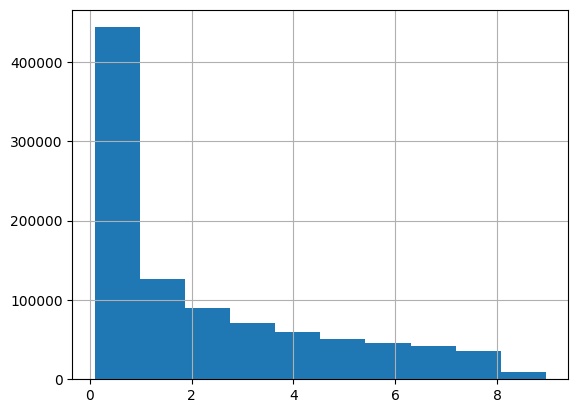

In [ ]:
dfs = []
df = train[["series_id", "step", "wakeup_oof"]].copy()
df["event"] = "wakeup"
df["score"] = df["wakeup_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

df = train[["series_id", "step", "onset_oof"]].copy()
df["event"] = "onset"
df["score"] = df["onset_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

train = pd.concat(dfs)
train = train[train["score"]>0.1].reset_index(drop=True)
train["score"].hist()
len(train)

## Dynamic-Range NMS

In [ ]:
train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:10<00:00, 27.60it/s]


In [ ]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
labels = labels[labels["series_id"].isin(sub["series_id"].unique())]
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

score: 0.7788


event   tolerance
onset   12           0.238005
        36           0.653738
        60           0.764732
        90           0.808686
        120          0.842376
        150          0.859610
        180          0.877822
        240          0.894382
        300          0.901651
        360          0.908875
wakeup  12           0.356092
        36           0.648148
        60           0.748724
        90           0.794709
        120          0.837284
        150          0.852487
        180          0.872371
        240          0.892862
        300          0.907541
        360          0.915377
dtype: float64

In [ ]:
%cp -r logs {CFG["output_dir"]}